수정사항
- augmentation 조정

In [1]:
# 시작 전에 GPU로 바꿔주기

# CNN 모델 만들고, ImageDataGenerator을 이용해서 학습 진행하기

In [2]:
# 필요한 module import
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# Google Drive 접근 = 구글 마운트하기
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## ImageDataGenerator 만들기 (rescale만 이용 / 다른 augmentation 제외)



In [28]:
# 이미지들이 있는 train, validation 폴더 가져오기
# 이 이미지들은 본인의 Local 파일에 각각 저장되어 있어야한다
# FinalProject에 있는 infant라는 폴더를 본인의 드라이브에 넣기!

train_dir = '/content/drive/MyDrive/KOSA3/project/data/infantface/train'
validation_dir = '/content/drive/MyDrive/KOSA3/project/data/infantface/valid'

In [29]:
# ImageDataGenerator 객체 생성

train_datagen = ImageDataGenerator(rescale=1/255) # 0 or 1의 값이 나올 수 있도록 255로 나누어 준다
validation_datagen=ImageDataGenerator(rescale=1/255)


# ImageDataGenerator 객체 세부 설정
# 넌 이렇게 동작해야해! 라고 세부 세팅을 해준다

train_generator = train_datagen.flow_from_directory( # train_datagen.flow_from_directory() 특정 폴더로부터 generator을 뽑아내는 객체를 하나 만든다
    train_dir, # target directory
    classes=['positive', 'neutral', 'negative'], # train 안에 있는 폴더를 내가 원하는 순서대로 준다 (positive -> neutral -> negative)
                                                 # label(target) 지정, list의 순서대로 지정하기!
                                                 # 만약 생략되면 폴더 순서는 오름차순으로 지정된다.
    target_size=(150, 150), #image resize
    batch_size=5, # 한번에 20개의 이미지를 가져온다
                   # label에 상관없이 이미지를 가져온다
    class_mode='categorical' # 다중분류 : categorical, 이진분류 : binary
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    classes=['positive', 'neutral', 'negative'],
    target_size=(150, 150), # 평가 데이터이기 떄문에 size를 똑같이 가져와야 한다
    batch_size=5,
    class_mode='categorical'
)

# Found 330 images belonging to 3 classes.
# Found 65 images belonging to 3 classes.

Found 330 images belonging to 3 classes.
Found 65 images belonging to 3 classes.


## CNN Model 구현

In [30]:
# 필터의 개수는 앞쪽에서 뒤쪽으로 갈 수록 많아지는 것이 좋다
# 필터의 크기(kernel_size)는 3x3 을 보통 쓴다

model = Sequential()

model.add(Conv2D(filters=32,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu',
                 input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu'))  # 여기서는 input_shape을 빼주어야한다
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=256,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# model.summary() # 중간에 확인해주고 넘어가기

model.add(Flatten())
model.add(Dropout(rate=0.5))
model.add(Dense(units=256,
                activation='relu'))
model.add(Dense(units=3,
                activation='softmax'))

model.summary()


# Total params: 3600707 (13.74 MB)
# Trainable params: 3600707 (13.74 MB) -> 학습이 가능한, 값이 바뀌는 파라미터

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 17, 17, 128)      

In [31]:
# model 학습 설정


model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# model checkpoint 확인
model_cp = ModelCheckpoint(filepath='infantface_checkpoint.ckpt', # 임시로 제공 받은 runtime disk에 파일이 만들어진다. 계산된 가중치를 저장해놓자
                           save_weights_only=True,
                           save_best_only=True,
                           monitor='val_loss',
                           verbose=1)

# model earlystopping 확인(조기 종료는 언제할까요?)
model_es = EarlyStopping(monitor='val_loss',
                         patience=5,
                         verbose=1,
                         restore_best_weights=True)


history = model.fit(train_generator,
                    steps_per_epoch=66,  # 1 epoch 당 몇 번 수행할지 정해주어야 한다. 이것도 직접 계산 330/5 = 66
                    epochs=100,
                    verbose=1,
                    #validation_split=0.3 이라고 썼었는데, 이제 validation_data가 따로 있기 때문에
                    validation_data=validation_generator,
                    validation_steps=13, # 계산해서 넣어주어야 한다
                                         # 즉, 65/5 = 13
                    callbacks=[model_cp, model_es])


model.save('./infantface_cnn_model.h5') # 학습이 끝나면, 우리 모델에 대해서 한 번에 딱 저장
# 저장하는 방법 2가지
# 1. checkpoint와 callback을 이용해서 epoch마다 저장해준다
# 2. 모델에 있어서 한 번에 저장


# 위 처럼 만들고 model 학습 진행 (shift+enter)

Epoch 1/100
65/66 [============================>.] - ETA: 0s - loss: 1.1069 - accuracy: 0.3785
Epoch 1: val_loss improved from inf to 1.08086, saving model to infantface_checkpoint.ckpt
66/66 [==============================] - 6s 59ms/step - loss: 1.1076 - accuracy: 0.3758 - val_loss: 1.0809 - val_accuracy: 0.4000
Epoch 2/100
66/66 [==============================] - ETA: 0s - loss: 1.0821 - accuracy: 0.4121
Epoch 2: val_loss improved from 1.08086 to 1.07613, saving model to infantface_checkpoint.ckpt
66/66 [==============================] - 3s 48ms/step - loss: 1.0821 - accuracy: 0.4121 - val_loss: 1.0761 - val_accuracy: 0.4000
Epoch 3/100
65/66 [============================>.] - ETA: 0s - loss: 1.0550 - accuracy: 0.4246
Epoch 3: val_loss improved from 1.07613 to 1.00665, saving model to infantface_checkpoint.ckpt
66/66 [==============================] - 3s 50ms/step - loss: 1.0534 - accuracy: 0.4242 - val_loss: 1.0066 - val_accuracy: 0.4308
Epoch 4/100
65/66 [=========================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# 마지막 결과값
# 66/66 [==============================] - 3s 45ms/step - loss: 0.0360 - accuracy: 0.9970 - val_loss: 0.5185 - val_accuracy: 0.8769
# Epoch 28: early stopping

# 기준을 어떻게 세워야 하는가?
# 1. loss, val_loss
# 기준 : 손실은 모델이 실제 값과 예측 값 간의 차이를 나타내므로, "낮을수록 좋다"
# 해석 : 훈련 손실과 검증 손실이 둘 다 감소하는 것은, 모델이 데이터에 잘 적함되고 있다는 것을 나타낸다.
#       그러나, 두 손실이 크게 차이나는 경우에는 과적합이 발생할 가능성이 있으므로 주의가 필요
# 2. accuracy, val_accuracy
# 기준 : 모델이 올바르게 분류한 샘플의 비율을 나타내므로, "높을수록 좋다"
# 해석 : 훈련 정확도와 검증 정확도가 둘 다 증가하는 것은 모델이 데이터를 잘 이해하고 일반화되고 있다는 것을 나타냅니다.
#       과적합이 발생하지 않도록 주의해야 합니다.

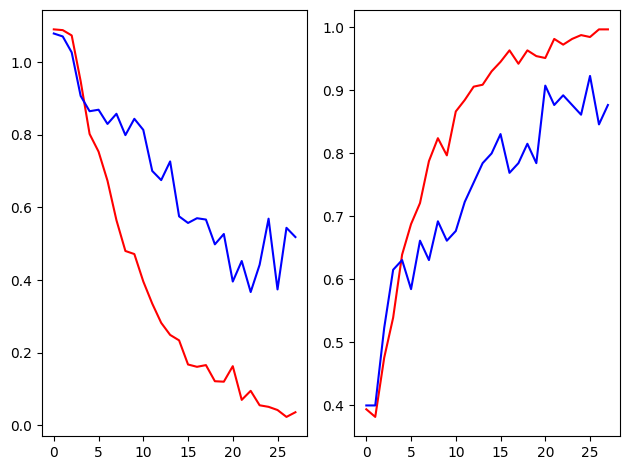

In [ ]:
# 결과 그래프를 그려보아요!
# 이때, 그래프를 해석할 줄 알아야 한다.
# 기준 : loss(훈련 손실)과 val_loss(검증 손실) 차이가 크지 않고,
#       accarcy(훈련 정확도) val_accuracy(검증 정확도)가 유사한지 확인해봐야한다.
# 해석 : 이러한 관계가 유지되면 모델이 새로운 데이터에 대해 일반화할 수 있음을 나타내며, 과적합이 발생하지 않았음을 이야기함.
# 만약, val_loss의 선인 파란선이 중간에 상승하는 모습을 보인다면 = Overfitting --> 차이가 생기기 시작하기 때문!

import matplotlib.pyplot as plt
fig = plt.figure()

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.plot(history.history['loss'], color='r')
ax1.plot(history.history['val_loss'], color='b')

ax2.plot(history.history['accuracy'], color='r')
ax2.plot(history.history['val_accuracy'], color='b')

plt.tight_layout()
plt.show()

In [ ]:
# Early Stopping 및 Model Checkpoint 콜백 활용
# 어떻게?
# Early Stopping과 Model Checkpoint 콜백을 사용하여 검증 손실이 더 이상 감소하지 않거나 증가하기 시작할 때 학습을 조기 종료하고 최적의 모델을 저장합니다.
# 해석
# 이는 모델이 더 이상 개선되지 않고 있거나 과적합이 시작될 때 학습을 중단하여 일반화된 모델을 얻을 수 있도록 도와줍니다.

**OverFitting 줄이는 방법**


1. Feature의 개수 줄이기
2. 규제(L1, L2)
3. Dropout

가장 중요한 방법은!
4. Data가 많으면 된다
   Image를 증식(Augmenation)을 이용해서 학습하면 되겠다!

   but, 증식 데이터는 '코드'를 구현해야 한다.

   이 코드는 ImageDataGenerator가 제공한다

## ImageDataGenerator을 이용해 overfitting 해결하기 (rescale을 비롯한 다른 augmentation 활용)

### 이미지 1장을 이용해 증식 사용해보기

In [ ]:
# 필요한 module import
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [ ]:
# 원하는 증식 정도를 모두 적어주기
datagen = ImageDataGenerator(rotation_range=20, # 회전 각도를 주어서 이미지를 변형
                             width_shift_range=0.1, # 10% 정도의 비율의 범위 내에서만 이동해라
                             height_shift_range=0.1,
                             shear_range=0.1,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest' # 이미지가 생길 수 있는 빈 공간이 생기는데 그 빈공간을 'nearest'로 근처에 있는 픽셀의 값으로 채워라)
                             )

<class 'PIL.Image.Image'>
<class 'numpy.ndarray'> (150, 150, 3)
(1, 150, 150, 3)


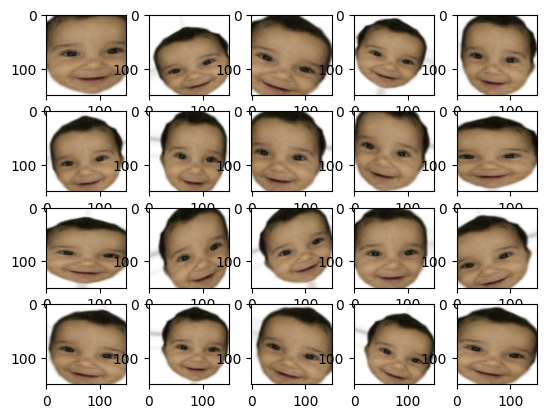

In [ ]:
# 원하는 이미지 1장을 증식해보기!
img = image.load_img('/content/drive/MyDrive/KOSA3/project/data/infantface/train/positive/Pos1.bmp',
                     target_size=(150,150))

# 원래는 numpy array가 나와야 함
# 확인
print(type(img)) # <class 'PIL.Image.Image'> --> numpy array가 아니기 때문에 이로 바꾸어주어야함

# numpy array로 바꿔줌
x = image.img_to_array(img)
print(type(x), x.shape)  # <class 'numpy.ndarray'> (150, 150, 3)
# 현재 이미지가 1장이다. 이 이미지에 대해서 ImageDataGenerator를 이용해서
# Augmentation(증식)된 이미지를 뽑을것이다.

# 그런데 ImageDataGenerator은 여러장의 이미지를 추출하는 거라서
# 기본적으로 4차원이 필요하다 (하지만, 현재 가지고 있는 것은 3차원이다)
x = x.reshape((1,) + x.shape) # x라는 4차원 데이터를 준비
print(x.shape)  # (1, 150, 150, 3)



# 증식된 이미지 20장을 그려보자
# 이미지의 개수를 확 늘려서(데이터의 개수를 늘려서)
# overfitting을 줄이자!

fig = plt.figure()
axs = []

for i in range(20):
    axs.append(fig.add_subplot(4,5,i+1))

idx = 0
for batch in datagen.flow(x, batch_size=1):
    axs[idx].imshow(image.array_to_img(batch[0]))
    idx += 1
    if idx % 20 == 0:
        break;

### 증식을 이용해 학습 진행해보기


In [8]:
# 필요한 module import
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
# ImageDataGenerator 생성

#  dir 불러오기
train_dir = '/content/drive/MyDrive/KOSA3/project/data/infantface/train'
validation_dir = '/content/drive/MyDrive/KOSA3/project/data/infantface/valid'

# ImageDataGenerator를 생성(객체 생성)
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1/255)

# ImageDataGenerator 객체 세부 설정
# 넌 이렇게 동작해야해! 라고 세부 세팅을 해준다

train_generator = train_datagen.flow_from_directory(
    train_dir,
    classes=['positive', 'neutral', 'negative'],
    target_size=(150, 150),
    batch_size=5,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    classes=['positive', 'neutral', 'negative'],
    target_size=(150, 150),
    batch_size=5,
    class_mode='categorical'
)

Found 330 images belonging to 3 classes.
Found 65 images belonging to 3 classes.


In [10]:
# Model 구현
# 위에서 만든 Model과 똑같음 (copy&paste)

model = Sequential()

model.add(Conv2D(filters=32,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu',
                 input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=256,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(rate=0.5))
model.add(Dense(units=256,
                activation='relu'))
model.add(Dense(units=3,
                activation='softmax'))

수정한 것
1.  EarlyStopping의 patience 수를 높임
    66/66 [==============================] - 5s 69ms/step - loss: 0.8461 - accuracy: 0.5939 - val_loss: 1.0182 - val_accuracy: 0.5846
Epoch 6: early stopping
-> 학습결과가 좋지 않아서
2. earlystopping을 없앰

In [11]:
# Model 학습 설정 및 진행

# model 학습 설정
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# model checkpoint 확인
model_cp = ModelCheckpoint(filepath='infantface_checkpoint.ckpt',
                           save_weights_only=True,
                           save_best_only=True,
                           monitor='val_loss',
                           verbose=1)

# model earlystopping 확인(조기 종료는 언제할까요?)
model_es = EarlyStopping(monitor='val_loss',
                         patience=5,
                         verbose=1,
                         restore_best_weights=True)



history = model.fit(train_generator,
                    steps_per_epoch=66,
                    epochs=100,
                    verbose=1,
                    validation_data=validation_generator,
                    validation_steps=13,
                    callbacks=[model_cp])


model.save('./infantface_IDG_cnn_model.h5')

Epoch 1/100
66/66 [==============================] - ETA: 0s - loss: 1.1052 - accuracy: 0.3606
Epoch 1: val_loss improved from inf to 1.09145, saving model to infantface_checkpoint.ckpt
66/66 [==============================] - 7s 75ms/step - loss: 1.1052 - accuracy: 0.3606 - val_loss: 1.0914 - val_accuracy: 0.3385
Epoch 2/100
66/66 [==============================] - ETA: 0s - loss: 1.0943 - accuracy: 0.3667
Epoch 2: val_loss improved from 1.09145 to 1.08538, saving model to infantface_checkpoint.ckpt
66/66 [==============================] - 6s 84ms/step - loss: 1.0943 - accuracy: 0.3667 - val_loss: 1.0854 - val_accuracy: 0.4000
Epoch 3/100
66/66 [==============================] - ETA: 0s - loss: 1.0912 - accuracy: 0.3909
Epoch 3: val_loss improved from 1.08538 to 1.07737, saving model to infantface_checkpoint.ckpt
66/66 [==============================] - 5s 74ms/step - loss: 1.0912 - accuracy: 0.3909 - val_loss: 1.0774 - val_accuracy: 0.4000
Epoch 4/100
66/66 [=========================

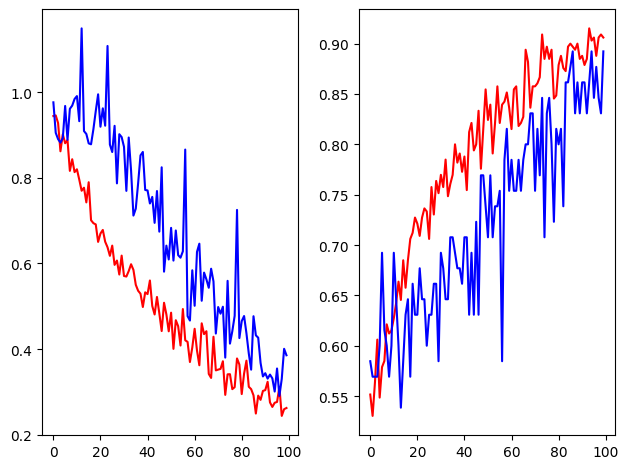

In [ ]:
# 결과 그래프를 그려보아요!

fig = plt.figure()

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.plot(history.history['loss'], color='r')
ax1.plot(history.history['val_loss'], color='b')

ax2.plot(history.history['accuracy'], color='r')
ax2.plot(history.history['val_accuracy'], color='b')

plt.tight_layout()
plt.show()

- 학습 데이터가 부족할 때, 데이터의 양을 늘리기 위해 증식을 사용
- 이는 overfitting을 줄이는 것
- 이 모델 자체의 accuracy를 높이는 것은 아님

**이를 해결하기 위해 바로 아래의 Pretrained Network를 이용해야 한다**

# 여기까지 모델로 Test 진행

In [15]:
# 테스트에 필요한 module import
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

In [42]:
# 저장된 모델 파일의 경로
saved_model_path = '/content/infantface_cnn_model.h5'

# 테스트할 이미지 경로 설정
test_image_path = '/content/drive/MyDrive/KOSA3/project/data/test_neg2.png'

# 모델 로드
loaded_model = load_model(saved_model_path)

# 이미지 불러오기 및 전처리
img = image.load_img(test_image_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

In [43]:
# 모델 예측
predictions = loaded_model.predict(img_array)

# 예측 결과 해석 및 출력
class_indices = np.argmax(predictions, axis=1)

# 각 클래스의 인덱스에 따른 레이블 설정 (positive, neutral, negative)
class_labels = ['positive', 'neutral', 'negative']
predicted_label = class_labels[class_indices[0]]

print(f"Predicted Class: {predicted_label}")

1/1 [==============================] - 0s 73ms/step
Predicted Class: negative
